In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/welfake-dataset/WELFake_Dataset.csv


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import nltk
import re
import string
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
# load the dataset
df = pd.read_csv("/kaggle/input/welfake-dataset/WELFake_Dataset.csv")
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [11]:
df.isna().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [12]:
df['text'] = df['title'] + " " + df['text']
df = df[['text', 'label']]
df = df[df['text'].notna()]
df = df.reset_index(drop=True)
df.head()

,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1
2,"Bobby Jindal, raised Hindu, uses story of Chri...",0
3,SATAN 2: Russia unvelis an image of its terrif...,1
4,About Time! Christian Group Sues Amazon and SP...,1


In [13]:
df.isna().sum()

text     0
label    0
dtype: int64

In [14]:
new_df=df.copy()

In [15]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [16]:
new_df['text']=new_df['text'].apply(lambda x:review_cleaning(x))
new_df.head()

,text,label
0,law enforcement on high alert following threat...,1
1,unbelievable obama’s attorney general says mos...,1
2,bobby jindal raised hindu uses story of christ...,0
3,satan russia unvelis an image of its terrifyi...,1
4,about time christian group sues amazon and spl...,1


In [17]:
stop = stopwords.words('english')
new_df['text'] = new_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
new_df.head()

,text,label
0,law enforcement high alert following threats c...,1
1,unbelievable obama’s attorney general says cha...,1
2,bobby jindal raised hindu uses story christian...,0
3,satan russia unvelis image terrifying new ‘sup...,1
4,time christian group sues amazon splc designat...,1


In [18]:
max_words = 5000
maxlen = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(new_df['text'])
sequences = tokenizer.texts_to_sequences(new_df['text'])
X = pad_sequences(sequences, maxlen=maxlen)
y = new_df['label']
y = pd.get_dummies(y)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CNN

In [20]:
model = Sequential()
model.add(Embedding(max_words, 128, input_length=maxlen))
model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(2, activation='sigmoid'))

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          640000    
                                                                 
 conv1d (Conv1D)             (None, 96, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 681,154
Trainable params: 681,154
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
895/895 [==============================] - 60s 52ms/step - loss: 0.2379 - accuracy: 0.9013 - val_loss: 0.1711 - val_accuracy: 0.9344
Epoch 2/5
895/895 [==============================] - 11s 12ms/step - loss: 0.1064 - accuracy: 0.9617 - val_loss: 0.1500 - val_accuracy: 0.9438
Epoch 3/5
895/895 [==============================] - 9s 10ms/step - loss: 0.0439 - accuracy: 0.9878 - val_loss: 0.1655 - val_accuracy: 0.9474
Epoch 4/5
895/895 [==============================] - 8s 9ms/step - loss: 0.0126 - accuracy: 0.9976 - val_loss: 0.2045 - val_accuracy: 0.9438
Epoch 5/5
895/895 [==============================] - 6s 7ms/step - loss: 0.0029 - accuracy: 0.9998 - val_loss: 0.2244 - val_accuracy: 0.9469


In [24]:
y_pred0 = model.predict(X_test)
y_pred0 = [1 if x[1]>0.5 else 0 for x in y_pred0]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test.iloc[:,1], y_pred0))
print('Classification Report:')
print(classification_report(y_test.iloc[:,1], y_pred0))

448/448 [==============================] - 1s 2ms/step
Accuracy: 0.9465334078837014
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      7081
           1       0.95      0.95      0.95      7227

    accuracy                           0.95     14308
   macro avg       0.95      0.95      0.95     14308
weighted avg       0.95      0.95      0.95     14308



In [25]:
cm_cv = confusion_matrix(y_test.iloc[:,1],y_pred0)
cm_cv

array([[6685,  396],
       [ 369, 6858]])

In [26]:
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'

<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

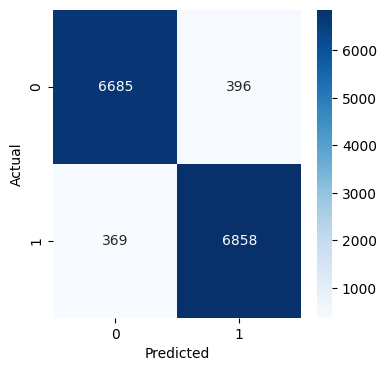

In [27]:
plt.figure(figsize = (4,4))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')

# LSTM

In [28]:
model_lstm = Sequential()
model_lstm.add(Embedding(max_words, 128, input_length=maxlen))
model_lstm.add(LSTM(64,dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(2, activation='sigmoid'))

In [29]:
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          640000    
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 689,538
Trainable params: 689,538
Non-trainable params: 0
_________________________________________________________________


In [31]:
model_lstm.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
895/895 [==============================] - 433s 480ms/step - loss: 0.2012 - accuracy: 0.9220 - val_loss: 0.1596 - val_accuracy: 0.9434
Epoch 2/5
895/895 [==============================] - 405s 452ms/step - loss: 0.1107 - accuracy: 0.9609 - val_loss: 0.1435 - val_accuracy: 0.9490
Epoch 3/5
895/895 [==============================] - 402s 449ms/step - loss: 0.0837 - accuracy: 0.9695 - val_loss: 0.1432 - val_accuracy: 0.9510
Epoch 4/5
895/895 [==============================] - 400s 447ms/step - loss: 0.0627 - accuracy: 0.9773 - val_loss: 0.1781 - val_accuracy: 0.9463
Epoch 5/5
895/895 [==============================] - 402s 449ms/step - loss: 0.0468 - accuracy: 0.9842 - val_loss: 0.1868 - val_accuracy: 0.9512


In [32]:
y_pred1 = model_lstm.predict(X_test)
y_pred1 = [1 if x[1]>0.5 else 0 for x in y_pred1]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test.iloc[:,1], y_pred1))
print('Classification Report:')
print(classification_report(y_test.iloc[:,1], y_pred1))

448/448 [==============================] - 14s 31ms/step
Accuracy: 0.9511462119094213
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7081
           1       0.94      0.96      0.95      7227

    accuracy                           0.95     14308
   macro avg       0.95      0.95      0.95     14308
weighted avg       0.95      0.95      0.95     14308



In [33]:
cm_cv = confusion_matrix(y_test.iloc[:,1],y_pred1)
cm_cv

array([[6660,  421],
       [ 278, 6949]])

In [34]:
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'

<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

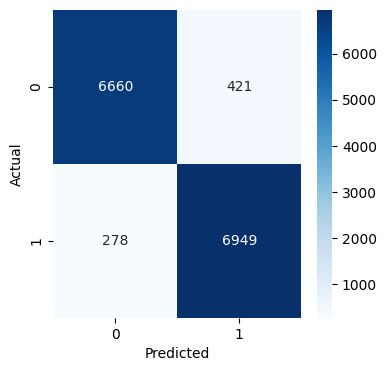

In [35]:
plt.figure(figsize = (4,4))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')

# Bi-Lstm

In [36]:
model_bilstm = Sequential()
model_bilstm.add(Embedding(max_words, 128, input_length=maxlen))
model_bilstm.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model_bilstm.add(Dense(2, activation='sigmoid'))

In [37]:
model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
model_bilstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 128)          640000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 739,074
Trainable params: 739,074
Non-trainable params: 0
_________________________________________________________________


In [39]:
model_bilstm.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
895/895 [==============================] - 818s 908ms/step - loss: 0.2050 - accuracy: 0.9194 - val_loss: 0.1505 - val_accuracy: 0.9458
Epoch 2/5
895/895 [==============================] - 798s 892ms/step - loss: 0.1101 - accuracy: 0.9600 - val_loss: 0.1390 - val_accuracy: 0.9490
Epoch 3/5
895/895 [==============================] - 788s 880ms/step - loss: 0.0761 - accuracy: 0.9721 - val_loss: 0.1484 - val_accuracy: 0.9484
Epoch 4/5
895/895 [==============================] - 793s 886ms/step - loss: 0.0529 - accuracy: 0.9813 - val_loss: 0.1623 - val_accuracy: 0.9501
Epoch 5/5
895/895 [==============================] - 788s 881ms/step - loss: 0.0356 - accuracy: 0.9877 - val_loss: 0.1877 - val_accuracy: 0.9504


In [40]:
y_pred2 = model_bilstm.predict(X_test)
y_pred2 = [1 if x[1]>0.5 else 0 for x in y_pred2]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test.iloc[:,1], y_pred2))
print('Classification Report:')
print(classification_report(y_test.iloc[:,1], y_pred2))

448/448 [==============================] - 26s 58ms/step
Accuracy: 0.9503075202683813
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7081
           1       0.94      0.96      0.95      7227

    accuracy                           0.95     14308
   macro avg       0.95      0.95      0.95     14308
weighted avg       0.95      0.95      0.95     14308



In [41]:
cm_cv = confusion_matrix(y_test.iloc[:,1],y_pred2)
cm_cv

array([[6665,  416],
       [ 295, 6932]])

In [42]:
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'

<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

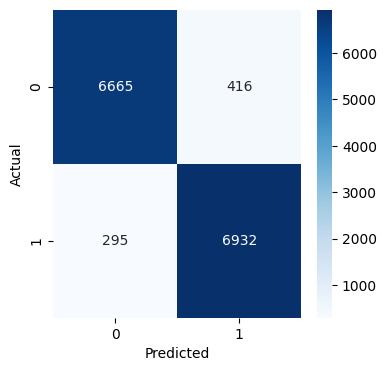

In [43]:
plt.figure(figsize = (4,4))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')